### 필요한 라이브러리 임포트

In [22]:
import os
import random
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

### 기본 전처리 정의

In [2]:
basic_transform_input = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
basic_transform_target = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

### JointAugmentation Class 정의
입력과 타깃 이미지에 동일하게 랜덤 회전 및 랜덤 크롭을 적용

In [3]:
class JointAugmentation:
    def __init__(self, rotation_range=30, crop_size=(256, 256)):
        self.rotation_range = rotation_range
        self.crop_size = crop_size

    def __call__(self, input_img, target_img):
        # 랜덤 회전
        angle = random.uniform(-self.rotation_range, self.rotation_range)
        input_img = TF.rotate(input_img, angle)
        target_img = TF.rotate(target_img, angle)
        # 랜덤 크롭: 입력 이미지에서 crop 파라미터를 구한 후 동일하게 적용
        i, j, h, w = transforms.RandomCrop.get_params(input_img, output_size=self.crop_size)
        input_img = TF.crop(input_img, i, j, h, w)
        target_img = TF.crop(target_img, i, j, h, w)
        return input_img, target_img

### RandomFlipAugmentation Class 정의
입력과 타깃 이미지에 랜덤 수평 및 (옵션) 수직 플립 적용

In [4]:
class RandomFlipAugmentation:
    def __init__(self, horizontal_prob=0.5, vertical_prob=0.0):
        self.horizontal_prob = horizontal_prob
        self.vertical_prob = vertical_prob

    def __call__(self, input_img, target_img):
        if random.random() < self.horizontal_prob:
            input_img = TF.hflip(input_img)
            target_img = TF.hflip(target_img)
        if random.random() < self.vertical_prob:
            input_img = TF.vflip(input_img)
            target_img = TF.vflip(target_img)
        return input_img, target_img

### CombinedAugmentation Class 정의
JointAugmentation과 RandomFlipAugmentation을 순차적으로 적용

In [5]:
class CombinedAugmentation:
    def __init__(self, joint_aug, flip_aug):
        self.joint_aug = joint_aug
        self.flip_aug = flip_aug

    def __call__(self, input_img, target_img):
        input_img, target_img = self.joint_aug(input_img, target_img)
        input_img, target_img = self.flip_aug(input_img, target_img)
        return input_img, target_img

### RestorationDataset Class 정의
CSV 파일에 기록된 경로 정보를 사용해 입력(흑백)과 타깃(컬러) 이미지를 로드하고 전처리 적용

In [6]:
class RestorationDataset(Dataset):
    def __init__(self, csv_file, input_dir, target_dir=None, transform_input=None, transform_target=None, joint_transform=None):
        """
        csv_file: 이미지 경로 정보가 저장된 CSV 파일 경로
        input_dir: 입력 이미지 디렉토리 (예: train_input)
        target_dir: 타깃 이미지 디렉토리 (예: train_gt); test 데이터인 경우 None
        transform_input: 입력 이미지에 개별적으로 적용할 전처리 (ex. ToTensor 등)
        transform_target: 타깃 이미지에 개별적으로 적용할 전처리
        joint_transform: 입력과 타깃 이미지에 동시에 적용할 전처리 (예: 랜덤 증강)
        """
        self.data = pd.read_csv(csv_file)
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform_input = transform_input
        self.transform_target = transform_target
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CSV에 저장된 경로에서 파일명만 추출하여 사용 (중복 경로 방지)
        input_file = os.path.basename(self.data.iloc[idx]['input_image_path'])
        input_path = os.path.join(self.input_dir, input_file)
        input_img = Image.open(input_path).convert('L')  # 흑백 변환

        if self.target_dir is not None:
            target_file = os.path.basename(self.data.iloc[idx]['gt_image_path'])
            target_path = os.path.join(self.target_dir, target_file)
            target_img = Image.open(target_path).convert('RGB')  # 컬러 변환
        else:
            target_img = None

        # joint_transform 적용 (있다면)
        if self.joint_transform is not None and target_img is not None:
            input_img, target_img = self.joint_transform(input_img, target_img)

        # 개별 transform 적용 (ToTensor 등)
        if self.transform_input:
            input_img = self.transform_input(input_img)
        if self.transform_target and target_img is not None:
            target_img = self.transform_target(target_img)

        return input_img, target_img

## 다양한 전처리 방식으로 데이터셋 구성

### 1. Basic Dataset: 단순 리사이즈 + ToTensor

In [7]:
basic_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    transform_input=basic_transform_input,
    transform_target=basic_transform_target
)

### 2. Joint Augmentation Dataset: 랜덤 회전 및 크롭 적용 후 ToTensor

In [8]:
joint_aug = JointAugmentation(rotation_range=30, crop_size=(256, 256))
joint_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    joint_transform=joint_aug,
    transform_input=transforms.ToTensor(),  # joint_transform 후 텐서 변환
    transform_target=transforms.ToTensor()
)

### 3. Random Flip Augmentation Dataset: 랜덤 플립 적용 후 ToTensor

In [9]:
flip_aug = RandomFlipAugmentation(horizontal_prob=0.7, vertical_prob=0.3)
flip_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    joint_transform=flip_aug,
    transform_input=transforms.ToTensor(),
    transform_target=transforms.ToTensor()
)

### 4. Combined Augmentation Dataset: JointAugmentation + RandomFlipAugmentation 적용 후 ToTensor

In [10]:
combined_aug = CombinedAugmentation(joint_aug, flip_aug)
combined_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    joint_transform=combined_aug,
    transform_input=transforms.ToTensor(),
    transform_target=transforms.ToTensor()
)

샘플이미지 시각화 함수

In [11]:
def visualize_samples(dataset, n_samples=10, title_prefix=""):
    """
    dataset: 시각화할 RestorationDataset 객체
    n_samples: 출력할 샘플 수
    title_prefix: 서브플롯 제목에 추가할 접두어 (예: "Basic", "Joint Augmentation" 등)
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(2 * n_samples, 4))
    fig.suptitle(f"{title_prefix} Preprocessing samples", fontsize=16)
    for i in range(n_samples):
        input_img, target_img = dataset[i]
        # 입력 이미지: 채널이 1이면 2D로 출력
        if input_img.shape[0] == 1:
            input_np = input_img.squeeze(0).numpy()
            axes[0, i].imshow(input_np, cmap='gray')
        else:
            input_np = input_img.numpy().transpose(1, 2, 0)
            axes[0, i].imshow(input_np)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Input {i+1}")
        # 타깃 이미지: (3, H, W) -> (H, W, 3)로 변환
        target_np = target_img.numpy().transpose(1, 2, 0)
        axes[1, i].imshow(target_np)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Target {i+1}")
    plt.tight_layout()
    plt.show()

## 각 전처리 방식별 샘플 시각화

Basic Dataset Samples


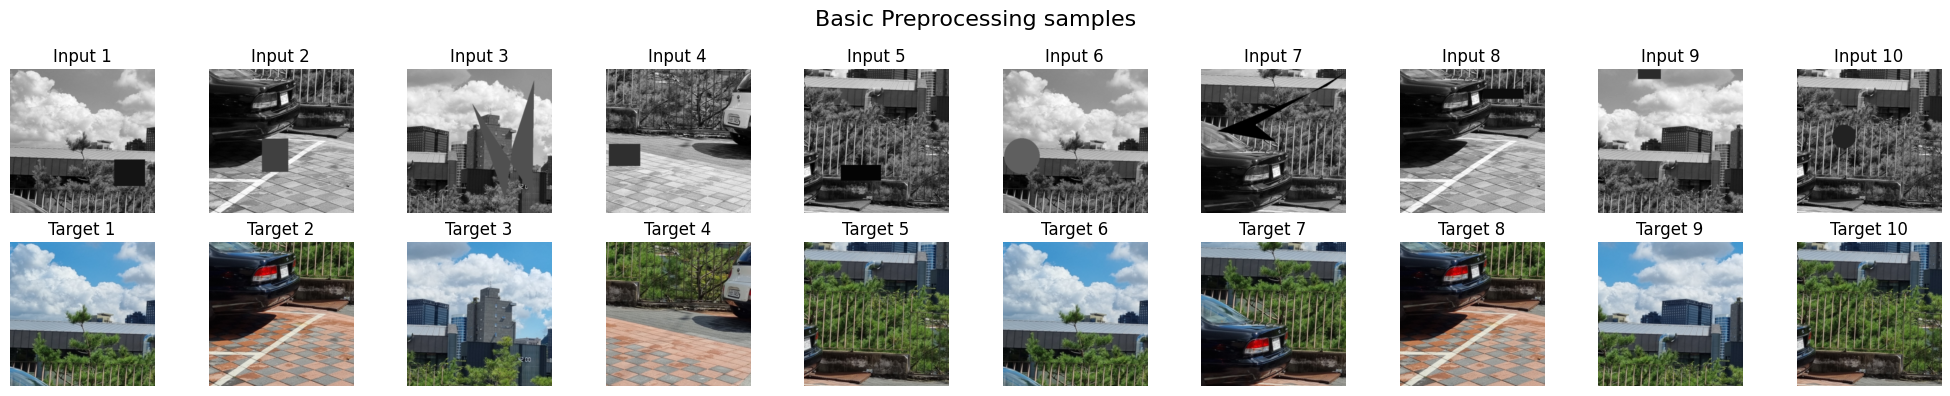

Joint Augmentation Dataset Samples


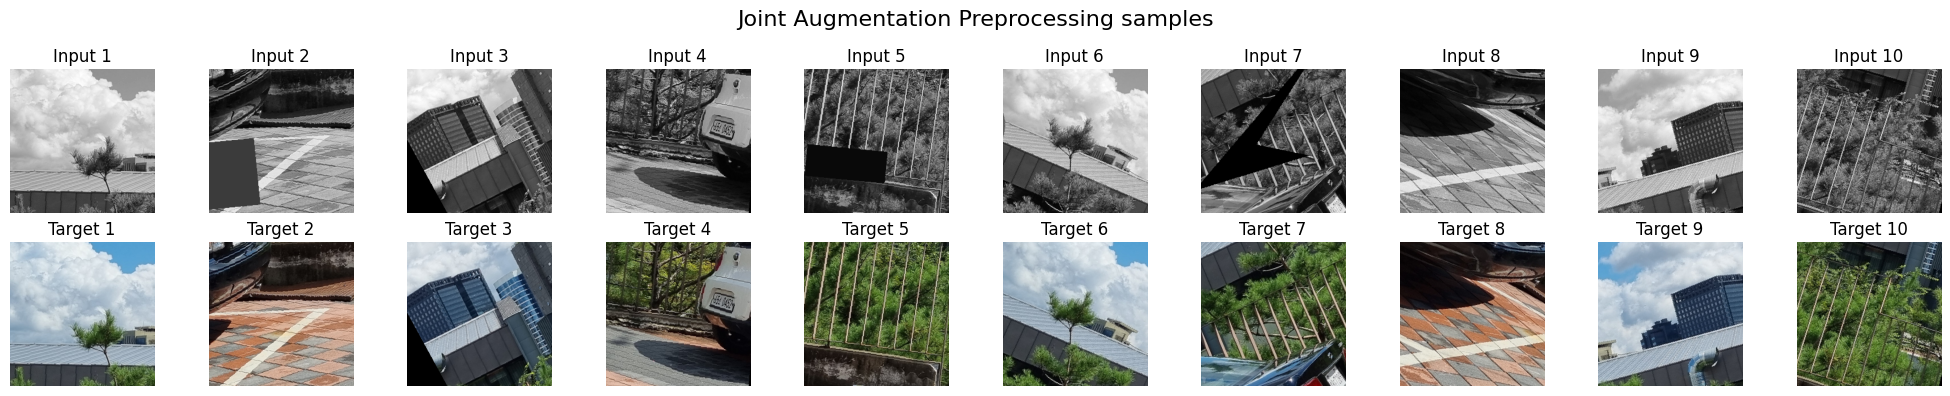

Random Flip Augmentation Dataset Samples


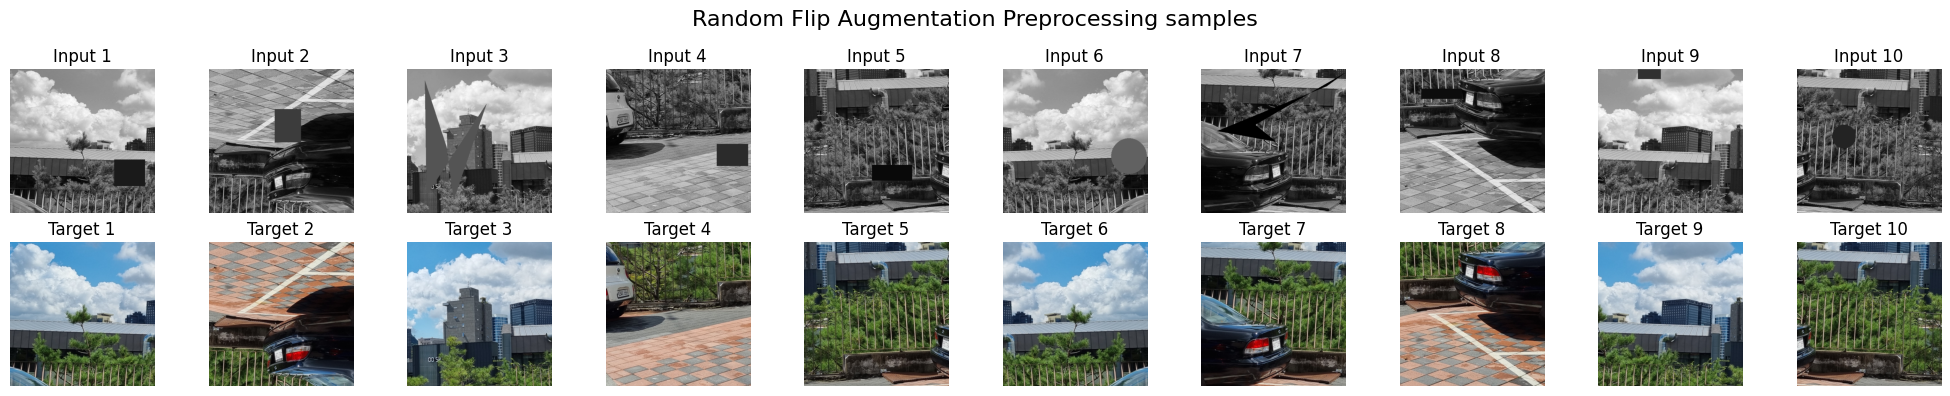

Combined Augmentation Dataset Samples


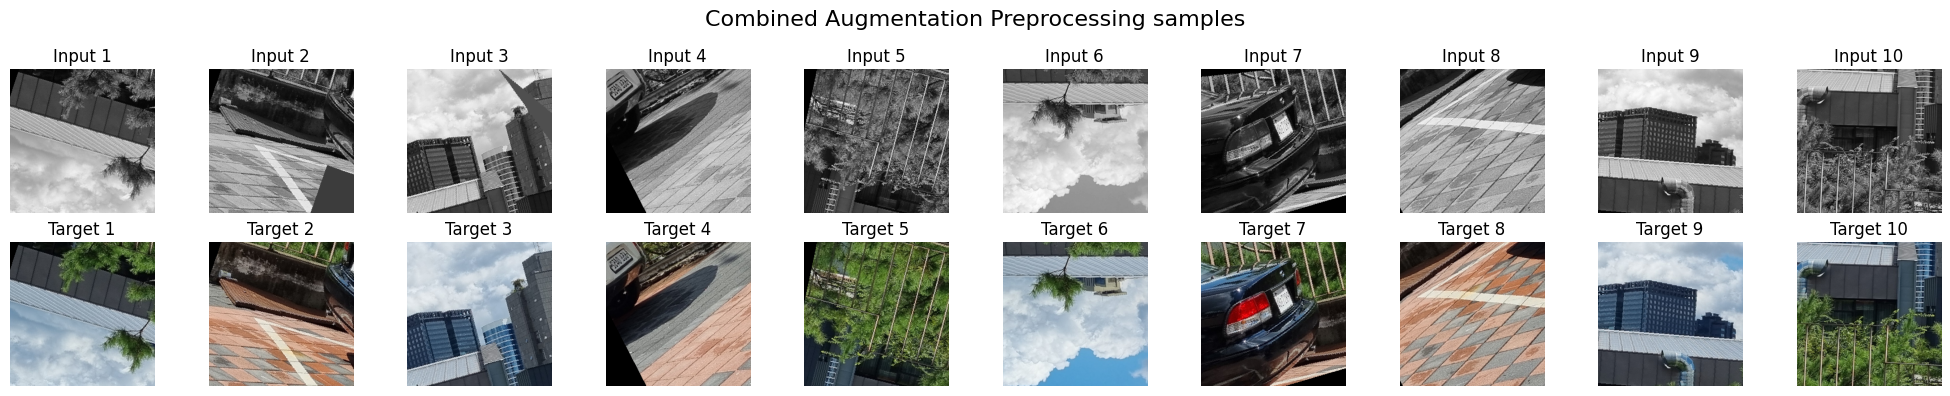

In [12]:
print("Basic Dataset Samples")
visualize_samples(basic_dataset, n_samples=10, title_prefix="Basic")

print("Joint Augmentation Dataset Samples")
visualize_samples(joint_dataset, n_samples=10, title_prefix="Joint Augmentation")

print("Random Flip Augmentation Dataset Samples")
visualize_samples(flip_dataset, n_samples=10, title_prefix="Random Flip Augmentation")

print("Combined Augmentation Dataset Samples")
visualize_samples(combined_dataset, n_samples=10, title_prefix="Combined Augmentation")

## CNN 모델 정의 및 구현!

### CNN 모델 정의

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 입력: 1 채널 -> 32 채널
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        # 32 채널 -> 64 채널
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        # 64 채널 -> 128 채널
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        # 128 채널 -> 64 채널
        self.conv4 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        # 64 채널 -> 32 채널
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        # 최종 출력: 32 채널 -> 3 채널 (컬러 이미지 복원)
        self.conv_final = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.relu5(self.conv5(x))
        x = self.conv_final(x)
        return x

### 2. Test Dataset 정의

In [14]:
class TestDataset(Dataset):
    def __init__(self, csv_file, input_dir, transform=None):
        """
        csv_file: test 이미지 경로가 기록된 CSV 파일
        input_dir: test 이미지가 저장된 폴더 (예: test_input)
        transform: 이미지에 적용할 전처리 (예: Resize, ToTensor 등)
        """
        self.data = pd.read_csv(csv_file)
        self.input_dir = input_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CSV에 기록된 경로에서 파일명만 추출 (중복 경로 방지를 위함)
        input_file = os.path.basename(self.data.iloc[idx]['input_image_path'])
        input_path = os.path.join(self.input_dir, input_file)
        # 흑백 이미지로 로드 (결함 이미지)
        img = Image.open(input_path).convert('L')
        if self.transform:
            img = self.transform(img)
        return img

### 3. 전처리 정의 및 TestDataset 생성

In [15]:
train_transform_input = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])
train_transform_target = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

# 학습용 데이터셋 / 로더
train_dataset = RestorationDataset(
    csv_file='train.csv',
    input_dir='train_input',
    target_dir='train_gt',
    transform_input=train_transform_input,
    transform_target=train_transform_target
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)

# 테스트용 데이터셋
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])
test_dataset = TestDataset(
    csv_file='test.csv',
    input_dir='test_input',
    transform=test_transform
)

### 4. 모델 인스턴스 생성

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
simple_cnn = SimpleCNN().to(device)
print(simple_cnn)

cuda
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace=True)
  (conv_final): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
)


### 5. 복구된 이미지 10개 (2행 x 5열) 시각화 함수

In [17]:
def visualize_recovered(model, dataset, n_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(n_samples):
        # test 데이터셋은 입력 이미지 하나만 반환
        input_img = dataset[i]
        # 입력 이미지는 (C, H, W) => 배치 차원 추가
        input_tensor = input_img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
        # 출력: (1, 3, H, W) -> squeeze 및 CPU로 이동
        output_img = output.squeeze(0).cpu().numpy()
        # (3, H, W) -> (H, W, 3)
        output_img = output_img.transpose(1, 2, 0)
        # 간단한 정규화 (0~1)
        output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min() + 1e-5)
        ax = axes[i // 5, i % 5]
        ax.imshow(output_img)
        ax.axis("off")
        ax.set_title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

### 6. 학습전 이미지 시각화 실행

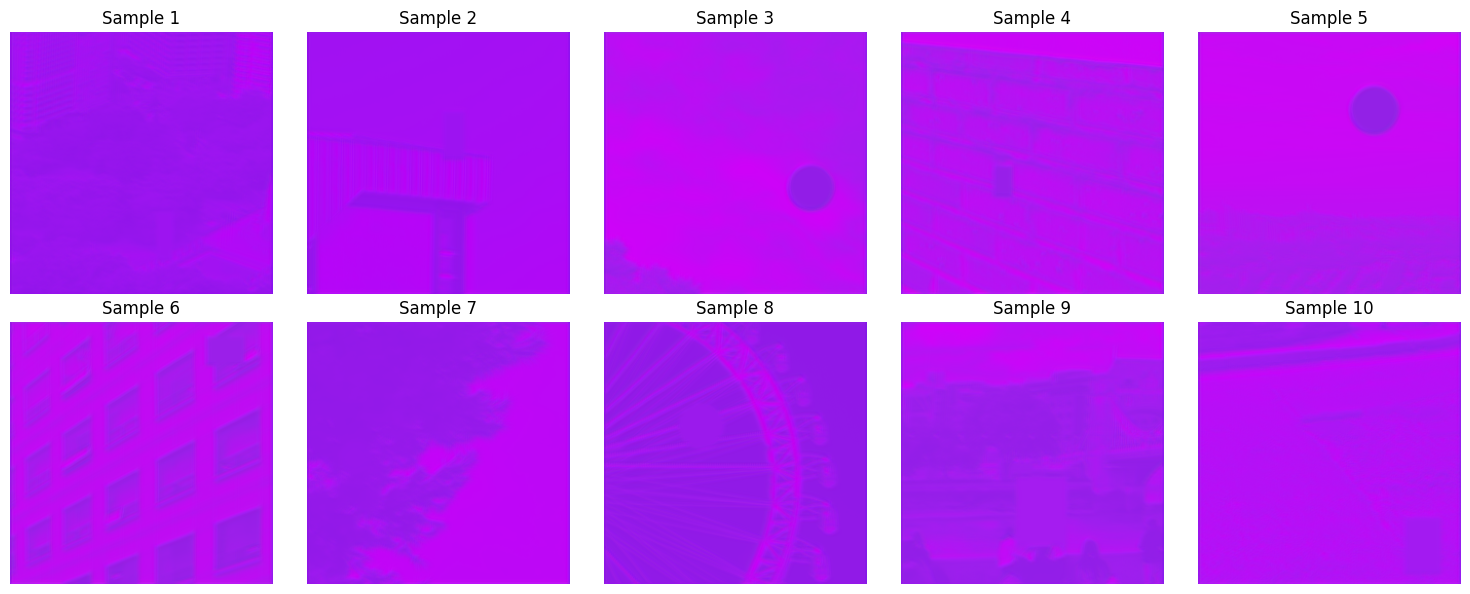

In [18]:
visualize_recovered(simple_cnn, test_dataset, n_samples=10)

### 7. 학습 루프 구현

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn = SimpleCNN().to(device)

# 손실 함수 (예: L1 Loss)
criterion = nn.L1Loss()
# 옵티마이저 (예: Adam)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    model_cnn.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

### 테스트 결과 시각화

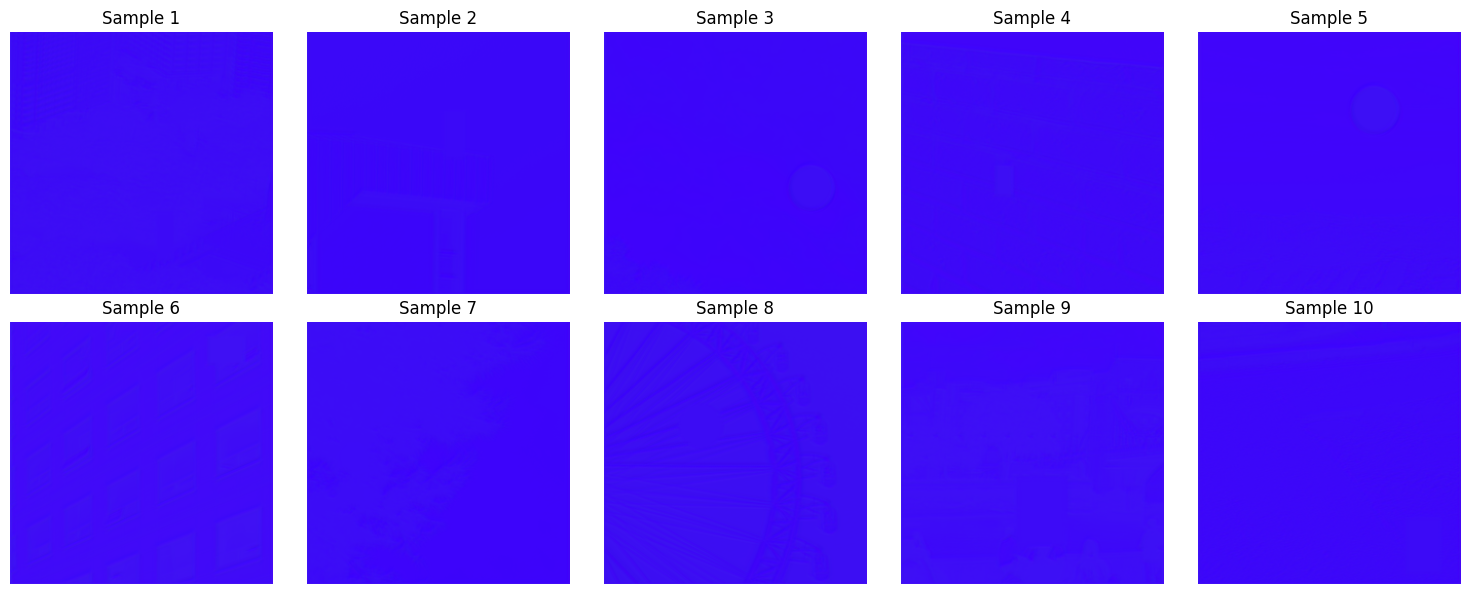

In [40]:
def visualize_cnn_results(model, test_dataset, n_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(n_samples):
        input_img = test_dataset[i]
        # (C, H, W) -> (1, C, H, W)
        input_tensor = input_img.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)  # (1, 3, H, W)

        # 모델 출력 -> CPU
        output_img = output.squeeze(0).cpu().numpy()  # (3, H, W)
        output_img = output_img.transpose(1, 2, 0)    # (H, W, 3)

        # 단순 정규화 (시각화를 위해)
        out_min, out_max = output_img.min(), output_img.max()
        output_img = (output_img - out_min) / (out_max - out_min + 1e-8)

        ax = axes[i//5, i%5]
        ax.imshow(output_img)
        ax.axis("off")
        ax.set_title(f"Sample {i+1}")

    plt.tight_layout()
    plt.show()

# 학습 후, CNN 결과 시각화
visualize_cnn_results(model_cnn, test_dataset, n_samples=10)


## Unet 모델 정의 및 구현!

### Unet 모델 정의

In [26]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # 인코더
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # 디코더
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # 최종 출력: 64 채널 -> 3 채널 (컬러 복원)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # 인코더
        e1 = self.enc_conv1(x)      # (batch, 64, H, W)
        p1 = self.pool1(e1)         # (batch, 64, H/2, W/2)

        e2 = self.enc_conv2(p1)     # (batch, 128, H/2, W/2)
        p2 = self.pool2(e2)         # (batch, 128, H/4, W/4)

        e3 = self.enc_conv3(p2)     # (batch, 256, H/4, W/4)
        p3 = self.pool3(e3)         # (batch, 256, H/8, W/8)

        # Bottleneck
        b = self.bottleneck(p3)     # (batch, 512, H/8, W/8)

        # 디코더
        d3 = self.upconv3(b)        # (batch, 256, H/4, W/4)
        d3 = torch.cat([d3, e3], dim=1)  # (batch, 512, H/4, W/4)
        d3 = self.dec_conv3(d3)     # (batch, 256, H/4, W/4)

        d2 = self.upconv2(d3)       # (batch, 128, H/2, W/2)
        d2 = torch.cat([d2, e2], dim=1)  # (batch, 256, H/2, W/2)
        d2 = self.dec_conv2(d2)     # (batch, 128, H/2, W/2)

        d1 = self.upconv1(d2)       # (batch, 64, H, W)
        d1 = torch.cat([d1, e1], dim=1)  # (batch, 128, H, W)
        d1 = self.dec_conv1(d1)     # (batch, 64, H, W)

        out = self.final_conv(d1)   # (batch, 3, H, W)
        return out

### test 데이터셋 정의

In [27]:
class TestDataset(Dataset):
    def __init__(self, csv_file, input_dir, transform=None):
        """
        csv_file: test 이미지 경로가 기록된 CSV 파일
        input_dir: test 이미지가 저장된 폴더 (예: test_input)
        transform: 전처리 (예: Resize, ToTensor 등)
        """
        self.data = pd.read_csv(csv_file)
        self.input_dir = input_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_file = os.path.basename(self.data.iloc[idx]['input_image_path'])
        input_path = os.path.join(self.input_dir, input_file)
        img = Image.open(input_path).convert('L')
        if self.transform:
            img = self.transform(img)
        return img

### 전처리 정의 및 TestDataset 생성

In [28]:
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

test_dataset = TestDataset(
    csv_file='test.csv',  # 'input_image_path' 컬럼만 존재
    input_dir='test_input',
    transform=test_transform
)

### Unet 모델 인스턴스 생성

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
unet_model = UNet().to(device)
print(unet_model)

cuda
UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck)

### 복구된 이미지 10개 시각화함수

In [30]:
def visualize_unet(model, dataset, n_samples=10):
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(n_samples):
        # test 데이터셋은 입력 이미지 하나만 반환
        input_img = dataset[i]
        input_tensor = input_img.unsqueeze(0).to(device)  # 배치 차원 추가
        with torch.no_grad():
            output = model(input_tensor)
        # 출력: (1, 3, H, W)
        output_img = output.squeeze(0).cpu().numpy()  # (3, H, W)
        output_img = output_img.transpose(1, 2, 0)       # (H, W, 3)
        # 단순 정규화: 0~1 사이로 스케일링
        output_img = (output_img - output_img.min()) / (output_img.max() - output_img.min() + 1e-5)
        ax = axes[i // 5, i % 5]
        ax.imshow(output_img)
        ax.axis("off")
        ax.set_title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

### 실행

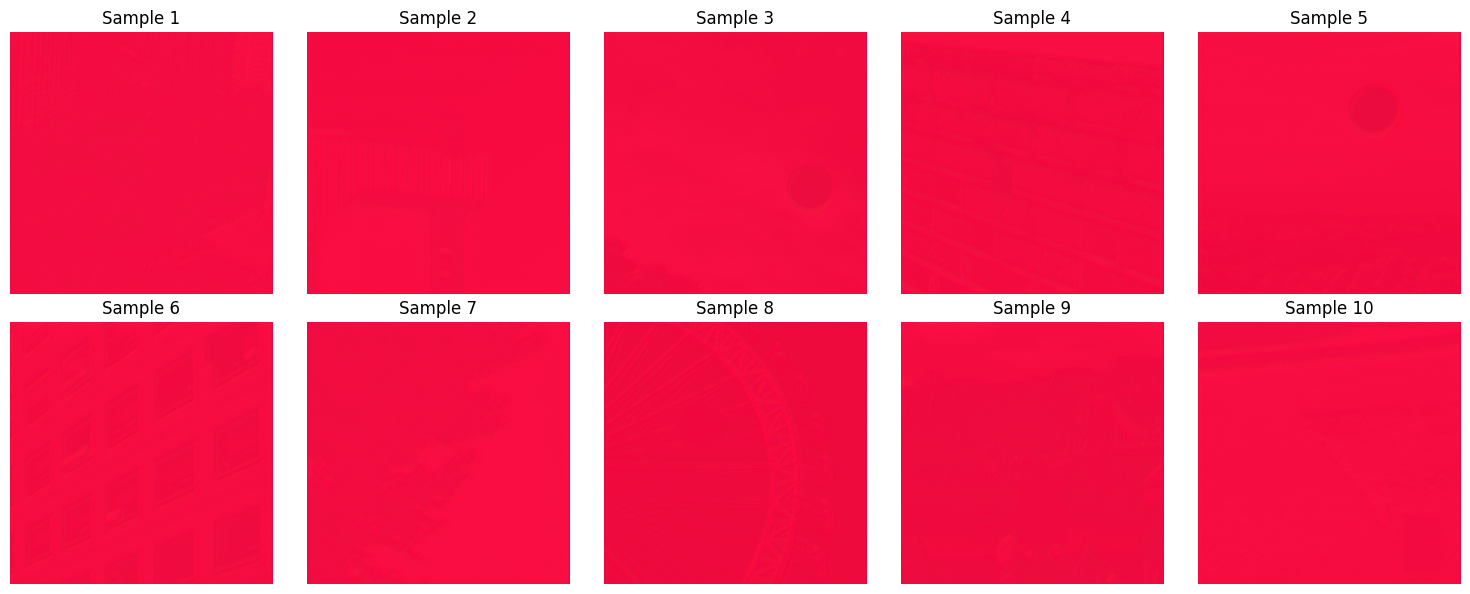

In [31]:
visualize_unet(unet_model, test_dataset, n_samples=10)

# Lama 공식 저장소 클론

In [13]:
!git clone https://github.com/saic-mdal/lama.git
!cd lama

!pip install -r requirements.txt

### Pycharm에선 잘 안되니, 직접 터미널 열어서 진행

'git'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
지정된 경로를 찾을 수 없습니다.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


# MAT

Patch 임베딩: 이미지를 패치로 나누어 선형 투영

In [14]:
from pytorch_msssim import ssim

class PatchEmbed(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=512):
        super(PatchEmbed, self).__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (img_size // patch_size) ** 2

    def forward(self, x):
        # x: (B, in_channels, H, W)
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1,2)  # (B, N, embed_dim), where N = H*W
        return x, (H, W)

간단한 Transformer 인코더

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, num_layers=6, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        # x: (B, N, embed_dim)
        return self.encoder(x)

MAT 모델

In [16]:
class MAT(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=1, embed_dim=512,
                 num_heads=8, num_layers=6, out_channels=3):
        """
        img_size: 입력 이미지 크기 (정사각형)
        patch_size: 패치 크기
        in_channels: 입력 채널 (흑백이면 1)
        embed_dim: 패치 임베딩 차원
        num_heads, num_layers: Transformer 인코더 설정
        out_channels: 최종 복원 이미지 채널 (컬러이면 3)
        """
        super(MAT, self).__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        # 위치 임베딩: 학습 가능한 파라미터로 N x embed_dim (N: 패치 수)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches, embed_dim))
        self.encoder = TransformerEncoder(embed_dim, num_heads, num_layers)
        # 복원 head: Transformer 출력을 이미지 패치로 변환
        self.decoder = nn.Linear(embed_dim, patch_size * patch_size * out_channels)
        self.patch_size = patch_size
        self.out_channels = out_channels

    def forward(self, x, mask=None):
        """
        x: (B, in_channels, H, W) – 입력 이미지 (여기서는 결함 있는 흑백 이미지)
        mask: (B, 1, H, W) – (선택사항) 복원할 영역 마스크; 여기선 단순화를 위해 사용하지 않음.
        """
        # 패치 임베딩
        x, (H, W) = self.patch_embed(x)  # (B, N, embed_dim)
        # 위치 임베딩 추가
        x = x + self.pos_embed
        # 만약 mask 정보가 있다면, 여기서 마스크에 해당하는 토큰에 대해 별도 처리(예: 마스크 토큰 삽입)를 할 수 있음.
        # Transformer 인코더 통과
        x = self.encoder(x)  # (B, N, embed_dim)
        # 각 패치에 대해 이미지 패치로 복원
        x = self.decoder(x)  # (B, N, patch_size*patch_size*out_channels)
        B, N, _ = x.shape
        # 패치들을 원래 이미지 형태로 재배열
        x = x.view(B, H, W, self.out_channels, self.patch_size, self.patch_size)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()  # (B, out_channels, H, patch_size, W, patch_size)
        x = x.view(B, self.out_channels, H * self.patch_size, W * self.patch_size)
        return x

예제: MAT 모델 인스턴스 생성 및 출력 확인

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mat_model = MAT(img_size=256, patch_size=16, in_channels=1, embed_dim=512,
                num_heads=8, num_layers=6, out_channels=3).to(device)
print(mat_model)
print(device)

MAT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 512, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder): TransformerEncoder(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (decoder): Linear(in_features=512, out_features=768, bias=True)
)
cuda


C:\Users\sunju\PycharmProjects\PythonProject\.venv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


간단한 테스트: 임의의 흑백 이미지에 대해 복원 결과 확인

In [18]:
dummy_input = torch.randn(1, 1, 256, 256).to(device)  # (B, 1, 256, 256)
with torch.no_grad():
    output = mat_model(dummy_input)
print("Output shape:", output.shape)   # 예상: (1, 3, 256, 256)

Output shape: torch.Size([1, 3, 256, 256])


시각화

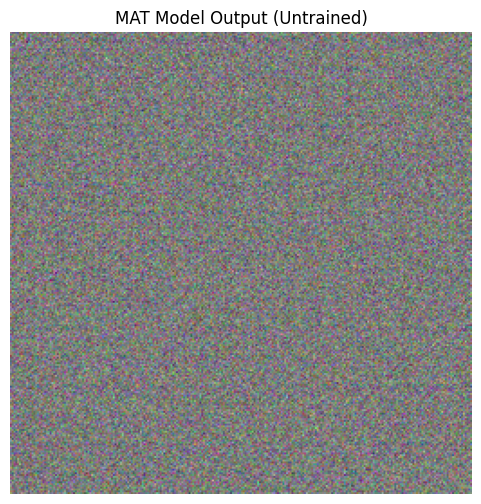

In [19]:
# (출력 이미지를 0~1 범위로 정규화)
out_img = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)
out_img = (out_img - out_img.min()) / (out_img.max() - out_img.min() + 1e-8)

plt.figure(figsize=(6,6))
plt.imshow(out_img)
plt.title("MAT Model Output (Untrained)")
plt.axis("off")
plt.show()

## 데이터 셋 정의

In [20]:
class RestorationDataset(Dataset):
    def __init__(self, csv_file, input_dir, target_dir=None, transform_input=None, transform_target=None):
        """
        csv_file: CSV 파일 (컬럼: 'input_image_path', 'gt_image_path')
        input_dir: 결함 있는 흑백 이미지 폴더 (예: train_input)
        target_dir: 원본 컬러 이미지 폴더 (예: train_gt)
        transform_input, transform_target: 각각의 전처리 함수 (예: Resize, ToTensor 등)
        """
        self.data = pd.read_csv(csv_file)
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # CSV에 기록된 경로에서 파일명만 추출
        input_file = os.path.basename(self.data.iloc[idx]['input_image_path'])
        input_path = os.path.join(self.input_dir, input_file)
        input_img = Image.open(input_path).convert('L')

        if self.target_dir is not None:
            target_file = os.path.basename(self.data.iloc[idx]['gt_image_path'])
            target_path = os.path.join(self.target_dir, target_file)
            target_img = Image.open(target_path).convert('RGB')
        else:
            target_img = None

        if self.transform_input:
            input_img = self.transform_input(input_img)
        if self.transform_target and target_img is not None:
            target_img = self.transform_target(target_img)

        return input_img, target_img

# 테스트용 데이터셋 (입력만)
class TestDataset(Dataset):
    def __init__(self, csv_file, input_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.input_dir = input_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_file = os.path.basename(self.data.iloc[idx]['input_image_path'])
        input_path = os.path.join(self.input_dir, input_file)
        img = Image.open(input_path).convert('L')
        if self.transform:
            img = self.transform(img)
        return img

## 전처리, 데이터로더, 하이퍼파라미터 설정

In [23]:
# 전처리 정의: 256x256, ToTensor
train_transform_input = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])
train_transform_target = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

# 데이터셋 생성 (CSV 파일 경로 및 폴더 경로는 상황에 맞게 수정)
train_dataset = RestorationDataset(csv_file='train.csv',
                                   input_dir='train_input',
                                   target_dir='train_gt',
                                   transform_input=train_transform_input,
                                   transform_target=train_transform_target)

# 학습 데이터셋을 80% / 검증 20% 로 분할
dataset_size = len(train_dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# DataLoader 생성
hyperparams = {
    'batch_size': 16,
    'lr': 1e-3,
    'epochs': 20,
}
train_loader = DataLoader(train_set, batch_size=hyperparams['batch_size'], shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=hyperparams['batch_size'], shuffle=False, num_workers=4)

# 테스트용 데이터셋
test_dataset = TestDataset(csv_file='test.csv', input_dir='test_input', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


## 모델, 손실 함수, 옵티마이저 설정

In [24]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mat = MAT(img_size=256, patch_size=16, in_channels=1, embed_dim=512,
                num_heads=8, num_layers=6, out_channels=3).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model_mat.parameters(), lr=hyperparams['lr'])

# SSIM을 기준으로 모델 성능 평가
best_ssim = 0.0
best_epoch = 0

C:\Users\sunju\PycharmProjects\PythonProject\.venv\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 학습 루프: 각 에포크마다 학습 후 검증, SSIM 개선 시 모델 저장

In [ ]:
train_losses = []
val_ssim_list = []

for epoch in range(hyperparams['epochs']):
    model_mat.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model_mat(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_set)
    train_losses.append(epoch_loss)

    # 검증: 전체 검증 셋에 대해 SSIM 평균 계산
    model_mat.eval()
    ssim_total = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model_mat(inputs)
            # [0,1] 범위로 클램핑
            outputs = torch.clamp(outputs, 0, 1)
            targets = torch.clamp(targets, 0, 1)
            batch_ssim = ssim(outputs, targets, data_range=1.0, size_average=True)
            ssim_total += batch_ssim.item() * inputs.size(0)
    avg_ssim = ssim_total / len(val_set)
    val_ssim_list.append(avg_ssim)

    print(f"Epoch {epoch+1}/{hyperparams['epochs']}  Loss: {epoch_loss:.4f}  Val SSIM: {avg_ssim:.4f}")

    # SSIM 개선 시 모델 저장 (checkpoint)
    if avg_ssim > best_ssim:
        best_ssim = avg_ssim
        best_epoch = epoch + 1
        torch.save(model_mat.state_dict(), "best_mat_model.pth")
        print(f"New best model saved with SSIM {best_ssim:.4f} at epoch {best_epoch}")

print(f"Training complete. Best SSIM: {best_ssim:.4f} at epoch {best_epoch}")

## 테스트: 저장된 베스트 모델 로드 후 복원 결과 시각화

In [ ]:
model_mat.load_state_dict(torch.load("best_mat_model.pth"))
model_mat.eval()

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i in range(10):
    # 테스트 데이터셋에서 이미지 하나씩 불러오기
    input_img = test_dataset[i]
    input_tensor = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model_mat(input_tensor)
    output = torch.clamp(output, 0, 1)
    output_np = output.squeeze(0).cpu().numpy().transpose(1,2,0)
    ax = axes[i//5, i%5]
    ax.imshow(output_np)
    ax.axis("off")
    ax.set_title(f"Sample {i+1}")
plt.tight_layout()
plt.show()